In [1]:
### Reloads modules properly
%load_ext autoreload
%autoreload 2

In [2]:
import os
os.sys.path.append('../')

# DBSCAN and FastHisto Comparison

In [3]:
import pandas as pd
import uproot
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import mplhep as hep
hep.style.use('CMS')
from tqdm import tqdm

In [4]:
from sklearn.cluster import DBSCAN

In [5]:
# storage = '/mnt/storage/lborgna/track/l1_nnt/'
storage = "/Volumes/ExternalSSD/track/l1_nnt/"
tp = pd.read_pickle(storage + 'tp.pkl')
trk = pd.read_pickle(storage + 'trk.pkl')
mc = pd.read_pickle(storage + 'mc.pkl')

## Pre-processing

In [6]:
trk = trk.loc[trk['trk_pt'] !=np.inf].copy()

In [144]:
(trk['trk_fake']>0.5).value_counts()

True     40058147
False      722493
Name: trk_fake, dtype: int64

In [7]:
trk['is_pv'] = 0
trk.loc[trk['trk_fake']==1,'is_pv']=1

In [8]:
trk

trk_pt   trk_eta   trk_phi  trk_d0    trk_z0  trk_fake  \
entry  subentry                                                             
0      0         2.623967  1.301414 -0.289234   999.0 -0.878906         2   
       1         3.435026  0.566814 -0.159267   999.0  3.339844         2   
       2         3.774908  1.815973 -0.240375   999.0  4.921875         1   
       3         2.641448 -1.435747 -0.128747   999.0 -0.468750         2   
       4         2.320653  1.837421  0.032604   999.0  4.980469         1   
...                   ...       ...       ...     ...       ...       ...   
222975 211       2.044568 -2.407456 -0.857553   999.0  1.113281         2   
       212       2.491473 -2.141478 -0.616329   999.0  8.847656         2   
       213       2.669393  2.230316 -0.748241   999.0 -0.234375         2   
       214       3.767222 -1.994298 -0.753691   999.0 -4.746094         2   
       215       1.988538 -2.052655 -0.790385   999.0  0.996094         2   

                 is_pv  
entry  subentry         
0      0             0  
       1             0  
       2             1  
       3             0  
       4             1  
...                ...  
222975 211           0  
       212           0  
       213           0  
       214           0  
       215           0  

[40780640 rows x 7 columns]

In [37]:
from pv_utils import (
    truth_pv_z0,
    # run_fast_histo,
    run_dbscan,
    primary_vertex_efficiency,
    plot_pv_efficiency_z0,
    plot_pv_resolution_z0,
    run_pv_fast_histo,
    run_pv_dbscan
)

In [10]:
z0_gen = truth_pv_z0(tp)

In [11]:
z0_mc = mc['pv_MC'].xs(0, axis = 0, level = 1, drop_level=True)

In [117]:
# be_fh = np.arange(-15, 15+0.15, 0.15)
be_fh = np.linspace(-15, 15, 256)

In [118]:
be_fh.shape[0]

256

In [125]:
halfbinwidth

0.0588235294117645

In [161]:
0.5*30.0/256.0

0.05859375

In [177]:
bin_width = be_fh[1]-be_fh[0]

In [178]:
bin_width

0.117647058823529

In [168]:
i_test = 126
halfbinwidth =0.5*(be_fh[1] - be_fh[0])
z0_test1 = -15.0 + (30.0)*(126.0)/256.0 + halfbinwidth
z0_test2 = be_fh[i_test+1] + halfbinwidth

In [14]:
tqdm.pandas()

**Corrected implementation of fast histo**

In [15]:
# def fast_histo_event(z0: np.array, pt: np.array, bin_edges: np.array) -> pd.Series:
#     "Event-level Fast Histo implementation to return the reconstructed primary vertex"

#     histo = np.histogram(z0, bins=bin_edges, weights=pt)[0]
    
#     histo = np.convolve(histo, [1,1,1], mode='same')
    
#     labels = np.zeros(len(z0), dtype=int)
    

#     max_idx = np.argmax(histo)

#     lower_bin_bound = bin_edges[max_idx]
#     upper_bin_bound = bin_edges[max_idx + 1]

#     in_max_bin_mask = (z0 > lower_bin_bound) & (z0 <= upper_bin_bound)
#     labels[in_max_bin_mask] = 1

#     return labels

In [16]:
# def run_pv_fast_histo(
#     df: pd.DataFrame,
#     bin_edges: np.array,
#     z0_column: str = "trk_z0",
#     pt_column: str = "trk_pt",
# ) -> np.array:
#     """Runs FastHisto over all of the events.

#     Args:
#         df (pd.DataFrame): Dataframe containing multiple events
#         bin_edges (np.array): bin edges to be used for FastHisto
#         z0_column (str, optional): column name containing track's z0 position. Defaults to "trk_z0".
#         pt_column (str, optional): column name containing tracks pt. Defaults to "trk_pt".

#     Returns:
#         np.array: Binary labels indicating if the track belongs to the primary vertex.
#     """
#     pv_fh = df.groupby(level=0).progress_apply(
#         lambda x: fast_histo_event(x[z0_column], x[pt_column], bin_edges)
#     )

#     pv_fh = pd.DataFrame(pv_fh, columns=["fh_label"])

#     pv_fh = pv_fh.explode("fh_label")

#     return pv_fh.values

In [112]:
def fast_histo_event(z0: np.array, pt: np.array, bin_edges: np.array, convolve:bool=True) -> pd.Series:
    "Event-level Fast Histo implementation to return the reconstructed primary vertex"

    histo = np.histogram(z0, bins=bin_edges, weights=pt)[0]

    if convolve:
        histo =np.convolve(histo, [1, 1, 1], mode="same")

    labels = np.zeros(len(z0), dtype=int)

    max_idx = np.argmax(histo)

    lower_bin_bound = bin_edges[max_idx]
    upper_bin_bound = bin_edges[max_idx + 1]

    # global max_idx_list
    # global max_idx_list_c
    # max_idx_list.append(max_idx)
    # max_idx_list_c.append(max_idx_c)

    in_max_bin_mask = (z0 > lower_bin_bound) & (z0 <= upper_bin_bound)
    labels[in_max_bin_mask] = 1

    return labels

def fast_histo_z0(z0: np.array, pt:np.array, bin_edges:np.array, convolve:bool=True)->pd.Series:
    
    histo = np.histogram(z0, bins=bin_edges, weights=pt)[0]
    
    if convolve:
        histo = np.convolve(histo, [1,1,1], mode='same')
    z0_index = np.argmax(histo)
    
    halfBinWidth = 0.5 *(bin_edges[1] -bin_edges[0])
    
    nbins = bin_edges.shape[0]
    
    z0 = bin_edges[0] + (bin_edges[-1]-bin_edges[0])*z0_index/nbins + halfBinWidth
    
    return z0

def run_pv_fast_histo(
    df: pd.DataFrame,
    bin_edges: np.array,
    z0_column: str = "trk_z0",
    pt_column: str = "trk_pt",
    z0_only:bool=True,
    convolve:bool=True
) -> np.array:
    """Runs FastHisto over all of the events.

    Args:
        df (pd.DataFrame): Dataframe containing multiple events
        bin_edges (np.array): bin edges to be used for FastHisto
        z0_column (str, optional): column name containing track's z0 position. Defaults to "trk_z0".
        pt_column (str, optional): column name containing tracks pt. Defaults to "trk_pt".

    Returns:
        np.array: Binary labels indicating if the track belongs to the primary vertex.
    """
    if z0_only:
        
        pv_fh = df.groupby(level=0).progress_apply(
            lambda x: fast_histo_z0(x[z0_column], x[pt_column], bin_edges, convolve)
        )
        return pv_fh
    else:
        
        pv_fh = df.groupby(level=0).progress_apply(
            lambda x: fast_histo_event(x[z0_column], x[pt_column], bin_edges, convolve)
        )

        pv_fh = pd.DataFrame(pv_fh, columns=["fh_label"])

        pv_fh = pv_fh.explode("fh_label")

        return pv_fh.values


In [111]:
max_idx_list = [] 
max_idx_list_c = []

In [113]:
trk['fh_label'] = run_pv_fast_histo(trk, bin_edges=be_fh, z0_only=False, convolve=False)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 222976/222976 [01:12<00:00, 3082.76it/s]


In [77]:
z0_fh_t = run_pv_fast_histo(trk, bin_edges=be_fh, z0_only=True)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 222976/222976 [00:37<00:00, 5888.46it/s]


In [42]:
dfd = pd.DataFrame({'max_idx':max_idx_list,'max_idx_c':max_idx_list_c,})

In [47]:
dfd['diff'] = np.abs(dfd['max_idx']-dfd['max_idx_c'])

In [53]:
bad_ones = list(dfd[dfd['diff'] > 6].index)

In [55]:
bad_ones_6_samples = bad_ones[0:6]

In [56]:
bad_ones_6_samples

[17, 81, 114, 318, 467, 486]

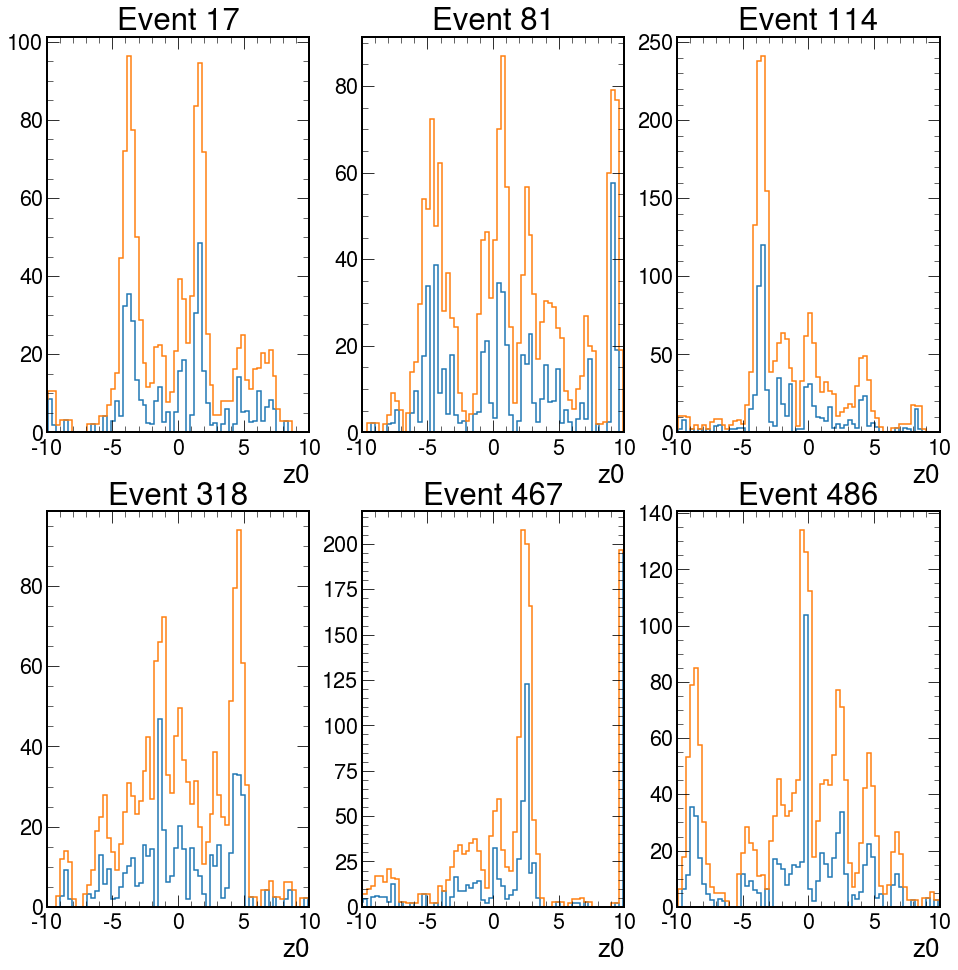

In [72]:
f, ax = plt.subplots(2,3, figsize = (16,16))
ax = ax.ravel()

for i, j in enumerate(bad_ones_6_samples):
    e = trk.query(f"entry=={j}")
    
    histo = np.histogram(e.trk_z0, bins=be_fh, weights=e.trk_pt)[0]
    
    histo_c = np.convolve(histo, [1,1,1], mode='same')
    
    hep.histplot(histo, be_fh, label = 'original histogram', ax=ax[i])
    hep.histplot(histo_c, be_fh, label = 'convolved histogram',ax=ax[i])
    ax[i].set_xlabel('z0')
    ax[i].set_xlim(-10,10)
    ax[i].set_title(f"Event {j}")

55 37
80 52
93 38
45 65
83 57
89 48


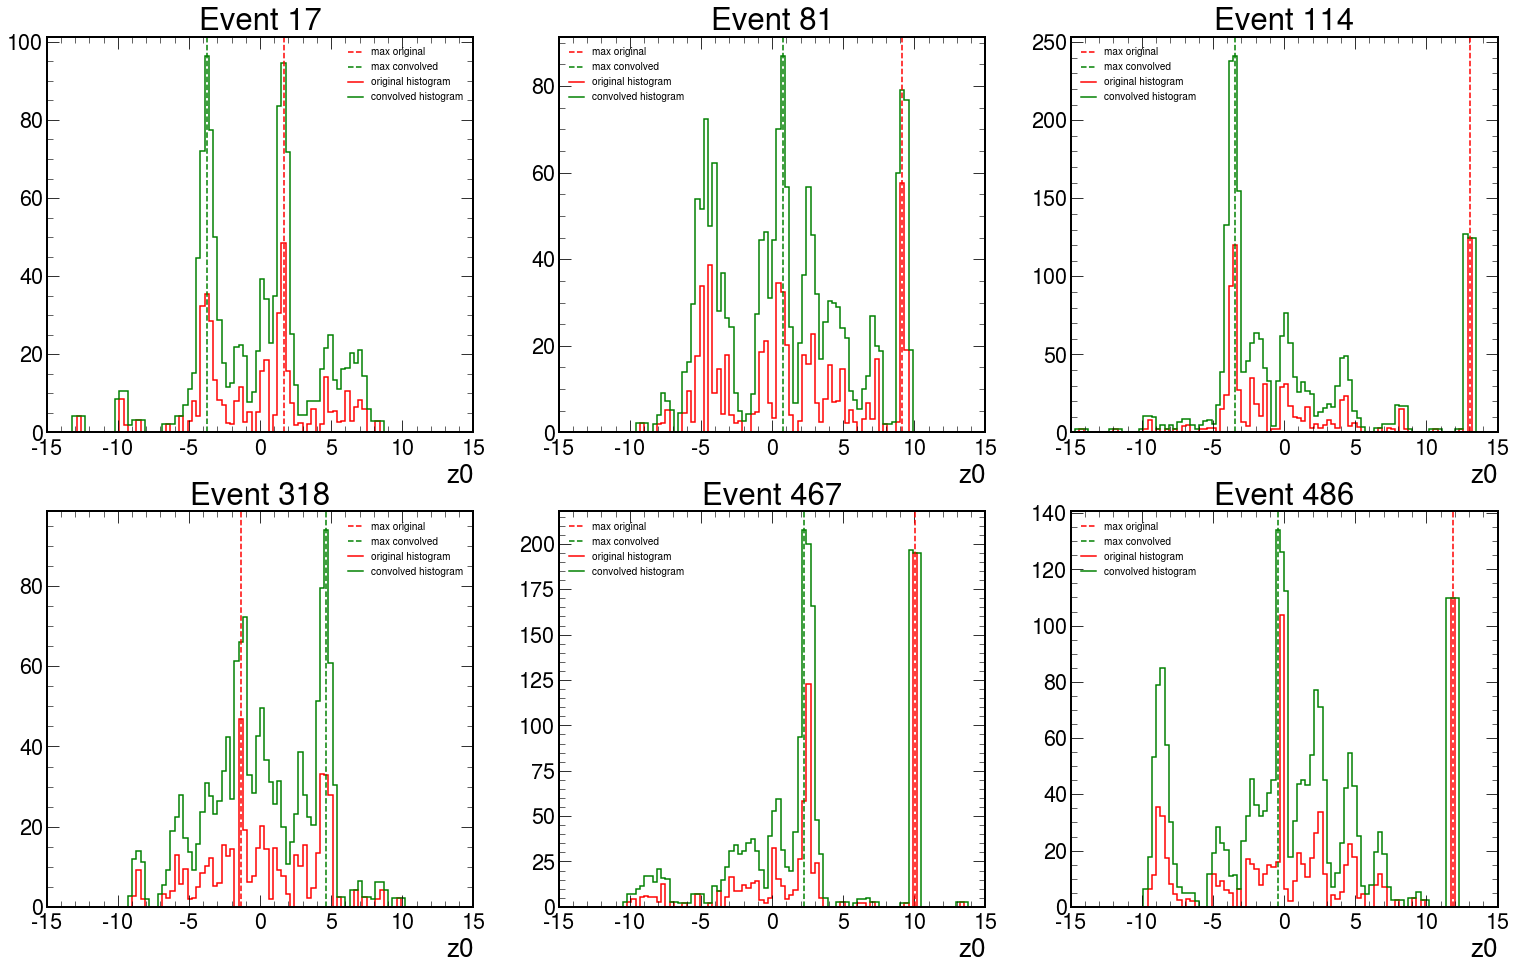

In [99]:
f, ax = plt.subplots(2,3, figsize = (26,16))
ax = ax.ravel()
hbw = 0.5*(be_fh[1] - be_fh[0])
for i, j in enumerate(bad_ones_6_samples):
    e = trk.query(f"entry=={j}")
    
    histo = np.histogram(e.trk_z0, bins=be_fh, weights=e.trk_pt)[0]
    idx_max =np.argmax(histo)
    histo_c = np.convolve(histo, [1,1,1], mode='same')
    idx_max_c = np.argmax(histo_c)
    print(idx_max, idx_max_c)
    
    lower_bound =  be_fh[idx_max] - 5
    upper_bound = be_fh[idx_max] + 5

    
    hep.histplot(histo, be_fh, label = 'original histogram', ax=ax[i], color= 'red')
    hep.histplot(histo_c, be_fh, label = 'convolved histogram',ax=ax[i], color='green')
    ax[i].axvline(be_fh[idx_max]+hbw, label = 'max original', color='red', ls='--')
    ax[i].axvline(be_fh[idx_max_c]+hbw, label = 'max convolved', color='green',ls='--')
    ax[i].set_xlabel('z0')
    ax[i].set_xlim(-15,15)
    ax[i].set_title(f"Event {j}")
    ax[i].legend(fontsize = 10)
plt.savefig('fast_histo_with_convolutions.pdf', dpi=600,bbox_inches='tight')

In [61]:
target = f"entry=={bad_ones_6_samples[0]}"
print(target)
trk.query(target)

entry==17


trk_pt   trk_eta   trk_phi  trk_d0    trk_z0  trk_fake  \
entry subentry                                                             
17    0         2.511198  0.093613 -0.189864   999.0  2.988281         2   
      1         2.699247  1.138209 -0.145157   999.0  1.347656         2   
      2         2.055166 -0.570164 -0.272392   999.0  3.339844         2   
      3         2.637682  1.260110 -0.114267   999.0 -1.171875         2   
      4         4.131747 -1.802891 -0.125814   999.0 -5.449219         2   
...                  ...       ...       ...     ...       ...       ...   
      127       2.052506 -1.062151 -0.311750   999.0 -4.394531         2   
      128       2.342195 -1.327834 -0.263926   999.0 -2.636719         2   
      129       2.462734  1.289476 -0.768557   999.0  1.171875         2   
      130       2.259720 -2.107424 -0.865997   999.0 -4.570312         2   
      131       2.142417  2.254924 -0.774624   999.0 -1.523438         2   

                is_pv fh_label  db_label  
entry subentry                            
17    0             0        0         0  
      1             0        0         0  
      2             0        0         0  
      3             0        0         0  
      4             0        0         0  
...               ...      ...       ...  
      127           0        0         0  
      128           0        0         0  
      129           0        0         0  
      130           0        0         0  
      131           0        0         0  

[132 rows x 9 columns]

In [48]:
dfd['diff'].value_counts()

0     124592
1      92329
4        298
5        277
6        267
       ...  
79         1
71         1
89         1
85         1
80         1
Name: diff, Length: 80, dtype: int64

In [41]:
max_idx_list

[66,
 38,
 49,
 59,
 45,
 37,
 49,
 31,
 55,
 40,
 79,
 38,
 49,
 35,
 33,
 47,
 55,
 55,
 33,
 69,
 53,
 52,
 67,
 60,
 42,
 56,
 45,
 46,
 54,
 37,
 49,
 49,
 52,
 66,
 38,
 49,
 59,
 31,
 56,
 50,
 49,
 66,
 49,
 58,
 40,
 49,
 45,
 47,
 49,
 29,
 56,
 30,
 50,
 58,
 36,
 49,
 29,
 71,
 31,
 62,
 50,
 42,
 54,
 42,
 46,
 55,
 17,
 48,
 49,
 45,
 38,
 79,
 63,
 88,
 61,
 64,
 33,
 58,
 60,
 65,
 58,
 80,
 65,
 66,
 86,
 66,
 43,
 46,
 31,
 66,
 66,
 58,
 41,
 80,
 63,
 43,
 64,
 50,
 52,
 63,
 22,
 43,
 47,
 55,
 50,
 63,
 47,
 44,
 56,
 55,
 24,
 58,
 33,
 32,
 93,
 54,
 59,
 46,
 35,
 66,
 56,
 44,
 60,
 43,
 45,
 30,
 43,
 40,
 43,
 47,
 48,
 49,
 45,
 38,
 33,
 58,
 55,
 52,
 30,
 42,
 39,
 51,
 65,
 47,
 69,
 66,
 42,
 45,
 59,
 44,
 54,
 63,
 49,
 51,
 49,
 43,
 29,
 52,
 79,
 35,
 68,
 28,
 50,
 33,
 37,
 61,
 47,
 31,
 74,
 77,
 30,
 58,
 48,
 35,
 51,
 40,
 45,
 58,
 34,
 48,
 46,
 40,
 76,
 60,
 50,
 61,
 58,
 54,
 61,
 58,
 74,
 92,
 56,
 56,
 59,
 52,
 63,
 67,
 45,
 56,


In [18]:
trk['db_label'] = run_pv_dbscan(trk)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 222976/222976 [11:10<00:00, 332.35it/s]


In [26]:
trk['fh_label'] = trk['fh_label'].astype(int)

# Primary Vertex Efficiency

In [20]:
from pv_utils import pv_z0_reco

In [114]:
z0_fh = pv_z0_reco(trk, reco_label = 'fh_label', z0_label = 'trk_z0')

In [22]:
z0_db = pv_z0_reco(trk, reco_label = 'db_label', z0_label='trk_z0')

In [79]:
primary_vertex_efficiency(z0_gen=z0_mc, z0_reco=z0_fh_t)

(29.97004161882893, 0.19011654695798086, 0.19063734859168946)

In [115]:
z0_fh.shape

(222976, 2)

In [104]:
primary_vertex_efficiency(z0_gen=z0_mc, z0_reco=z0_fh['trk_z0'])

(1.3194245120551091, 0.046952326089373164, 0.04822402014828975)

In [24]:
primary_vertex_efficiency(z0_gen=z0_mc, z0_reco=z0_db['trk_z0'])

(75.23679678530425, 0.17971013751598264, 0.1790538893312572)

In [31]:
z0_fh.shape

(222976, 2)

In [32]:
z0_db.shape

(222976, 2)

# Let's start over

**Simple approach, forget about track to vertex association, just calculate z0**

In [179]:
trk

trk_pt   trk_eta   trk_phi  trk_d0    trk_z0  trk_fake  \
entry  subentry                                                             
0      0         2.623967  1.301414 -0.289234   999.0 -0.878906         2   
       1         3.435026  0.566814 -0.159267   999.0  3.339844         2   
       2         3.774908  1.815973 -0.240375   999.0  4.921875         1   
       3         2.641448 -1.435747 -0.128747   999.0 -0.468750         2   
       4         2.320653  1.837421  0.032604   999.0  4.980469         1   
...                   ...       ...       ...     ...       ...       ...   
222975 211       2.044568 -2.407456 -0.857553   999.0  1.113281         2   
       212       2.491473 -2.141478 -0.616329   999.0  8.847656         2   
       213       2.669393  2.230316 -0.748241   999.0 -0.234375         2   
       214       3.767222 -1.994298 -0.753691   999.0 -4.746094         2   
       215       1.988538 -2.052655 -0.790385   999.0  0.996094         2   

                 is_pv fh_label  db_label  
entry  subentry                            
0      0             0        0         0  
       1             0        0         0  
       2             1        0         1  
       3             0        0         0  
       4             1        1         1  
...                ...      ...       ...  
222975 211           0        0         1  
       212           0        0         0  
       213           0        0         0  
       214           0        0         0  
       215           0        0         1  

[40780640 rows x 9 columns]

In [180]:
mc

,,pv_L1reco_z0,pv_L1reco_sum,pv_MC
entry,subentry,,,
0,0,5.026911,79.777252,5.055163
1,0,-2.021080,90.041313,-3.608661
2,0,-0.141508,202.421341,-0.261453
3,0,2.744174,303.983124,2.803285
4,0,-1.279072,218.012939,-1.400667
...,...,...,...,...
222971,0,-0.672085,223.375061,-0.698029
222972,0,0.576154,121.422821,0.520282
222973,0,-3.504717,167.360825,-3.604865


In [182]:
def fast_histo_z0_simple(z0: np.array, pt:np.array, bin_edges:np.array, convolve:bool=True)->pd.Series:
    
    histo = np.histogram(z0, bins=bin_edges, weights=pt)[0]
    
    if convolve:
        histo = np.convolve(histo, [1,1,1], mode='same')
    z0_index = np.argmax(histo)
    
    halfBinWidth = 0.5 *(bin_edges[1] -bin_edges[0])
    
    nbins = bin_edges.shape[0]
    
    z0 = bin_edges[0] + (bin_edges[-1]-bin_edges[0])*z0_index/nbins + halfBinWidth
    
    return z0

def run_pv_fast_histo_simple(
    df: pd.DataFrame,
    bin_edges: np.array,
    z0_column: str = "trk_z0",
    pt_column: str = "trk_pt",
    z0_only:bool=True,
    convolve:bool=True
) -> np.array:
    """Runs FastHisto over all of the events.

    Args:
        df (pd.DataFrame): Dataframe containing multiple events
        bin_edges (np.array): bin edges to be used for FastHisto
        z0_column (str, optional): column name containing track's z0 position. Defaults to "trk_z0".
        pt_column (str, optional): column name containing tracks pt. Defaults to "trk_pt".

    Returns:
        np.array: Binary labels indicating if the track belongs to the primary vertex.
    """
        
    pv_fh = df.groupby(level=0).progress_apply(
        lambda x: fast_histo_z0_simple(x[z0_column], x[pt_column], bin_edges, convolve)
    )
    return pv_fh

In [183]:
z0_reco_fh = run_pv_fast_histo_simple(trk, bin_edges=be_fh, z0_only=True, convolve=False)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 222976/222976 [00:37<00:00, 5908.31it/s]


In [268]:
be_fh[1]-be_fh[0]

0.117647058823529

In [269]:
bw = 0.2
be_te = np.arange(-15, 15+bw, bw)

In [273]:
z0_reco_fh_c = run_pv_fast_histo_simple(trk, bin_edges=be_fh, z0_only=True, convolve=True)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 222976/222976 [00:36<00:00, 6074.60it/s]


In [185]:
z0_reco_fh_c

entry
0         4.863511
1        -3.573989
2        -0.175551
3         2.754136
4        -1.464614
            ...   
222971   -0.644301
222972    0.176011
222973   -3.573989
222974   -4.511489
222975    1.347886
Length: 222976, dtype: float64

In [186]:
z0_reco_fh

entry
0         4.863511
1        -3.456801
2        -0.292739
3         2.636949
4        -1.347426
            ...   
222971   -0.644301
222972    0.761949
222973   -3.456801
222974   -4.511489
222975    1.465074
Length: 222976, dtype: float64

In [187]:
z0_mc

entry
0         5.055163
1        -3.608661
2        -0.261453
3         2.803285
4        -1.400667
            ...   
222971   -0.698029
222972    0.520282
222973   -3.604865
222974   -4.483971
222975    1.365169
Name: pv_MC, Length: 222976, dtype: float32

In [188]:
primary_vertex_efficiency(z0_gen=z0_mc, z0_reco=z0_reco_fh)

(48.51194747416762, 0.20764573326171387, 0.20768441928220227)

In [190]:
primary_vertex_efficiency(z0_gen=z0_mc, z0_reco=z0_reco_fh_c)

(56.31323550516647, 0.20617810860080255, 0.20601397688002976)

**Resolution**

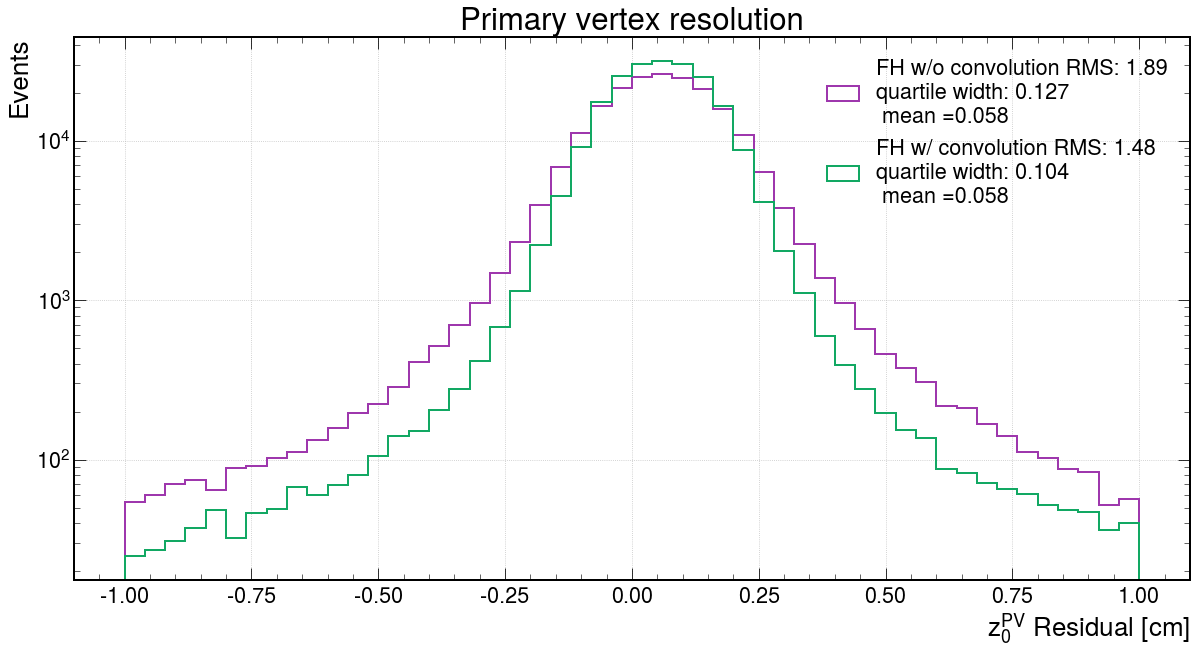

In [254]:
q = np.percentile((z0_mc-z0_reco_fh), [32, 50, 68])
q_c = np.percentile((z0_mc-z0_reco_fh_c), [32, 50, 68])



fig, ax = plt.subplots(1, 1, figsize=(20, 10))

RMS_q = np.sqrt(np.mean((z0_mc-z0_reco_fh)**2))
RMS_q_c = np.sqrt(np.mean((z0_mc-z0_reco_fh_c)**2))


quartile_q= round(q[2] - q[0],3)
quartile_q_c = round(q_c[2] - q_c[0],3)

RMS_q = round(RMS_q,2)
RMS_q_c = round(RMS_q_c,2)
label_fh = "RMS: " + str(RMS_q)
label_db = "RMS: " + str(RMS_q_c)

mean = np.median(z0_mc-z0_reco_fh)
mean_c = np.median(z0_mc-z0_reco_fh_c)

ax.hist(
    z0_mc - z0_reco_fh,
    bins=50,
    range=(-1, 1),
    histtype="step",
    label='FH w/o convolution ' + label_fh + '\nquartile width: ' + str(quartile_q)+f'\n mean ={round(mean,3)}',
    color="#9E37AD",lw=2
)


ax.hist(
    z0_mc - z0_reco_fh_c,
    bins=50,
    range=(-1, 1),
    histtype="step",
    label='FH w/ convolution ' + label_db + '\nquartile width: ' + str(quartile_q_c)+f'\n mean ={round(mean_c,3)}',
    color="#12A863",lw=2
)


ax.legend()

ax.grid(True)


ax.set_xlabel('$z^{PV}_0$ Residual [cm]',ha="right",x=1)
ax.set_ylabel('Events',ha="right",y=1)
ax.set_title('Primary vertex resolution')
ax.set_yscale('log')
# plt.savefig('histogram_resolution.pdf', dpi=500, bbox_inches='tight')



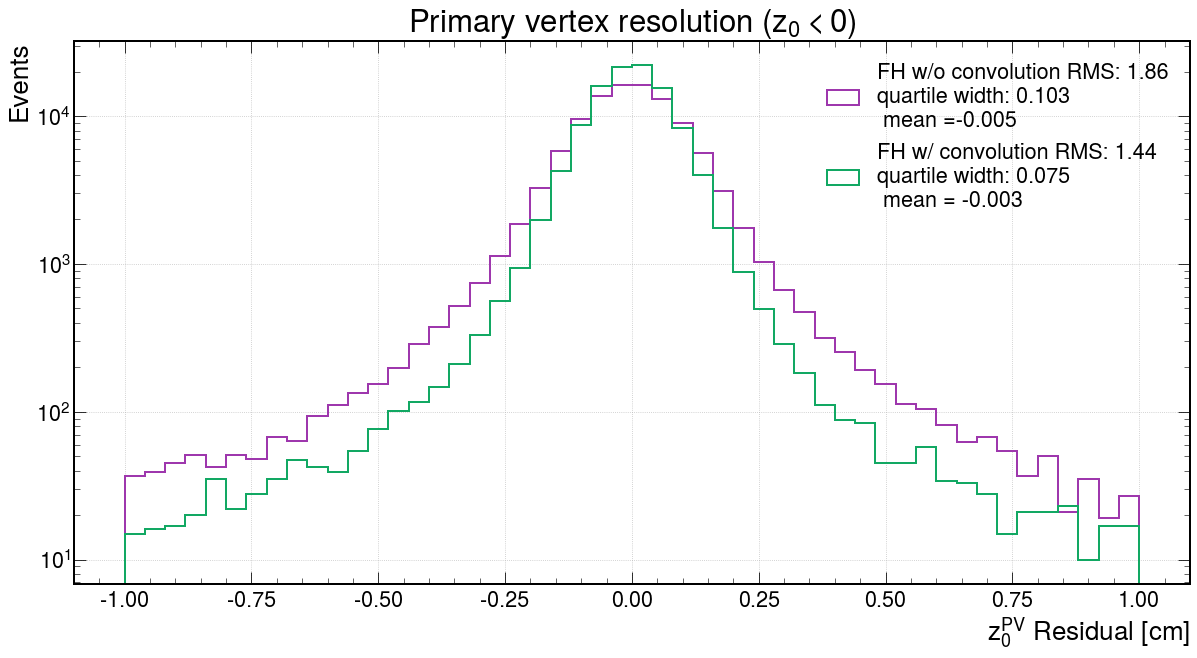

In [274]:
q = np.percentile((z0_mc[z0_mc<0]-z0_reco_fh[z0_mc<0]), [32, 50, 68])
q_c = np.percentile((z0_mc[z0_mc<0]-z0_reco_fh_c[z0_mc<0]), [32, 50, 68])



fig, ax = plt.subplots(1, 1, figsize=(20, 10))

RMS_q = np.sqrt(np.mean((z0_mc[z0_mc<0]-z0_reco_fh[z0_mc<0])**2))
RMS_q_c = np.sqrt(np.mean((z0_mc[z0_mc<0]-z0_reco_fh_c[z0_mc<0])**2))


quartile_q= round(q[2] - q[0],3)
quartile_q_c = round(q_c[2] - q_c[0],3)

RMS_q = round(RMS_q,2)
RMS_q_c = round(RMS_q_c,2)
label_fh = "RMS: " + str(RMS_q)
label_db = "RMS: " + str(RMS_q_c)
mean = np.median(z0_mc[z0_mc<0]-z0_reco_fh[z0_mc<0])
mean_c = np.median(z0_mc[z0_mc<0]-z0_reco_fh_c[z0_mc<0])

ax.hist(
    z0_mc[z0_mc<0] - z0_reco_fh[z0_mc<0],
    bins=50,
    range=(-1, 1),
    histtype="step",
    label='FH w/o convolution ' + label_fh + '\nquartile width: ' + str(quartile_q)+f'\n mean ={round(mean,3)}',
    color="#9E37AD",lw=2
)


ax.hist(
    z0_mc[z0_mc<0] - z0_reco_fh_c[z0_mc<0],
    bins=50,
    range=(-1, 1),
    histtype="step",
    label='FH w/ convolution ' + label_db + '\nquartile width: ' + str(quartile_q_c) + f'\n mean = {round(mean_c,3)}',
    color="#12A863",lw=2
)


ax.legend()

ax.grid(True)


ax.set_xlabel('$z^{PV}_0$ Residual [cm]',ha="right",x=1)
ax.set_ylabel('Events',ha="right",y=1)
ax.set_title('Primary vertex resolution ($z_0 < 0$)')
ax.set_yscale('log')
# plt.savefig('histogram_resolution.pdf', dpi=500, bbox_inches='tight')




0.21076045542897096
0.1538713036953047


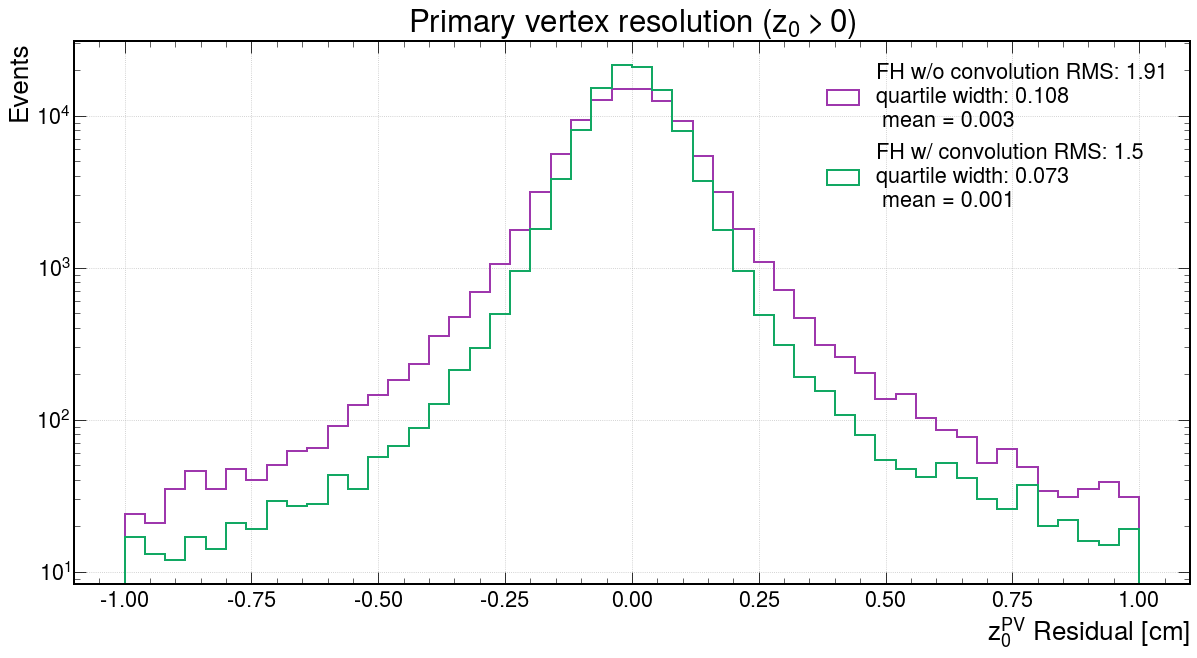

In [275]:
q = np.percentile((z0_mc[z0_mc>0]-z0_reco_fh[z0_mc>0]), [32, 50, 68])
q_c = np.percentile((z0_mc[z0_mc>0]-z0_reco_fh_c[z0_mc>0]), [32, 50, 68])



fig, ax = plt.subplots(1, 1, figsize=(20, 10))

RMS_q = np.sqrt(np.mean((z0_mc[z0_mc>0]-z0_reco_fh[z0_mc>0])**2))
RMS_q_c = np.sqrt(np.mean((z0_mc[z0_mc>0]-z0_reco_fh_c[z0_mc>0])**2))


quartile_q= round(q[2] - q[0],3)
quartile_q_c = round(q_c[2] - q_c[0],3)

RMS_q = round(RMS_q,2)
RMS_q_c = round(RMS_q_c,2)
label_fh = "RMS: " + str(RMS_q)
label_db = "RMS: " + str(RMS_q_c)

mean = np.median(z0_mc[z0_mc>0]-z0_reco_fh[z0_mc>0])
mean_c = np.median(z0_mc[z0_mc>0]-z0_reco_fh_c[z0_mc>0])

ax.hist(
    z0_mc[z0_mc>0] - z0_reco_fh[z0_mc>0],
    bins=50,
    range=(-1, 1),
    histtype="step",
    label='FH w/o convolution ' + label_fh + '\nquartile width: ' + str(quartile_q)+ f'\n mean = {round(mean,3)}',
    color="#9E37AD",lw=2
)


ax.hist(
    z0_mc[z0_mc>0] - z0_reco_fh_c[z0_mc>0],
    bins=50,
    range=(-1, 1),
    histtype="step",
    label='FH w/ convolution ' + label_db + '\nquartile width: ' + str(quartile_q_c)+ f'\n mean = {round(mean_c,3)}',
    color="#12A863",lw=2
)


ax.legend()

ax.grid(True)


ax.set_xlabel('$z^{PV}_0$ Residual [cm]',ha="right",x=1)
ax.set_ylabel('Events',ha="right",y=1)
ax.set_title('Primary vertex resolution ($z_0 > 0$)')
ax.set_yscale('log')
# plt.savefig('histogram_resolution.pdf', dpi=500, bbox_inches='tight')



print(np.mean(z0_mc[z0_mc>0] - z0_reco_fh[z0_mc>0]))
print(np.mean(z0_mc[z0_mc>0] - z0_reco_fh_c[z0_mc>0]))

Text(0, 1, '$z_0^{PV} - z_0^{reco}$ [cm]')

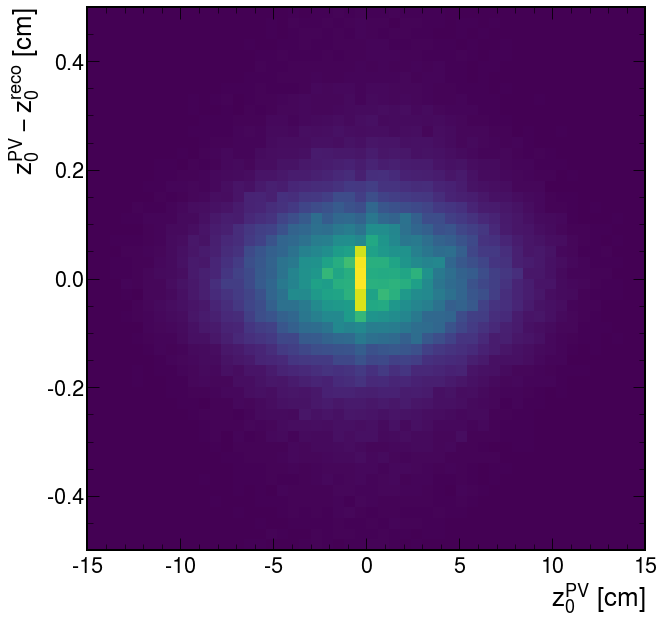

In [276]:
y = z0_mc - z0_reco_fh
x = z0_mc
_=plt.hist2d(x,y,bins=(50,50), range=((-15, 15), (-0.5, 0.5)))
plt.xlabel(r"$z_0^{PV}$ [cm]")
plt.ylabel(r"$z_0^{PV} - z_0^{reco}$ [cm]") 

Text(0, 1, '$z_0^{PV} - z_0^{reco}$ [cm]')

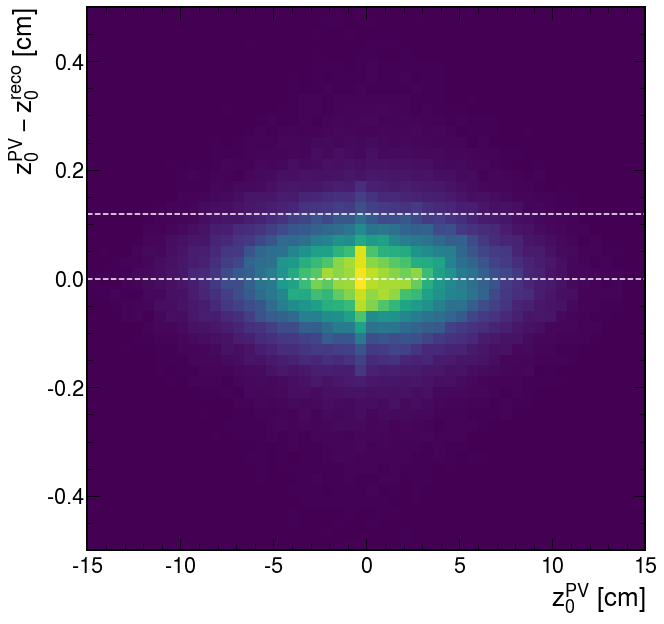

In [277]:
y = z0_mc - z0_reco_fh_c
x = z0_mc
_=plt.hist2d(x,y,bins=(50,50), range=((-15, 15), (-0.5, 0.5)))
plt.axhline(0.119, ls = '--',color='white')
plt.axhline(0, ls ='--',color='white')
plt.xlabel(r"$z_0^{PV}$ [cm]")
plt.ylabel(r"$z_0^{PV} - z_0^{reco}$ [cm]") 

In [263]:
def correct_mc_bias(z0_mc:np.array, z0_reco:np.array) -> np.array:
    positive_mask = z0_mc >= 0
    
    shift = np.median(z0_mc[positive_mask] - z0_reco[positive_mask])
    
    z0_mc[positive_mask] = z0_mc[positive_mask] - shift
    
    return z0_mc
    

In [264]:
z0_mc_cor = correct_mc_bias(z0_mc, z0_reco_fh_c)

Text(0.5, 1.0, 'Corrected Resolution spectrum')

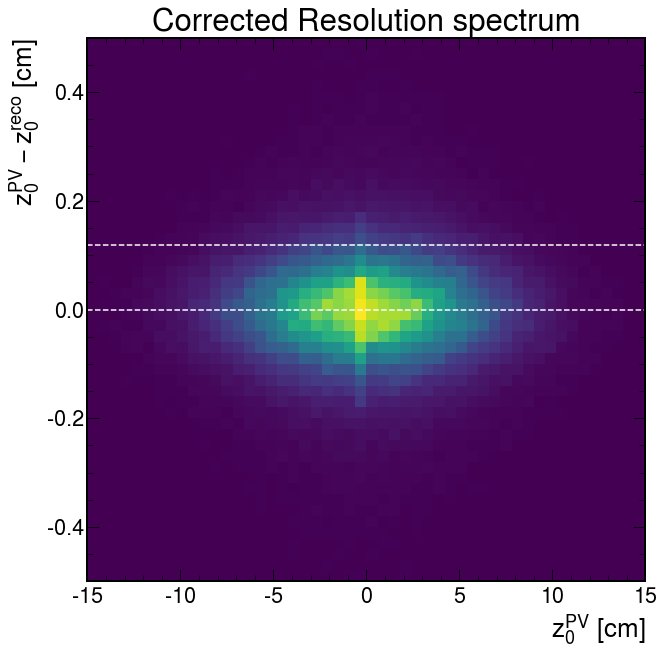

In [266]:
y = z0_mc_cor - z0_reco_fh_c
x = z0_mc_cor
_=plt.hist2d(x,y,bins=(50,50), range=((-15, 15), (-0.5, 0.5)))
plt.axhline(0.119, ls = '--',color='white')
plt.axhline(0, ls ='--',color='white')
plt.xlabel(r"$z_0^{PV}$ [cm]")
plt.ylabel(r"$z_0^{PV} - z_0^{reco}$ [cm]") 
plt.title('Corrected Resolution spectrum')

In [199]:
be = np.arange(-15, 15, 1)

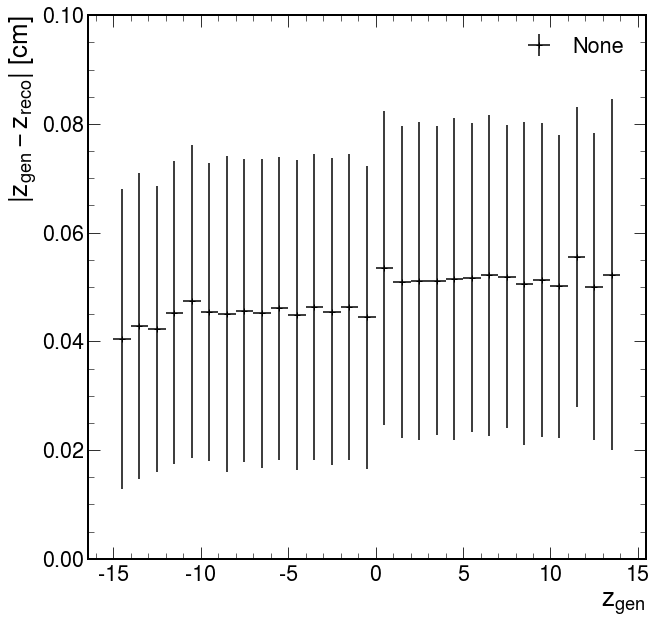

In [200]:
fh_res = plot_pv_resolution_z0(z0_gen = z0_mc, z0_reco=z0_reco_fh, bins =be)

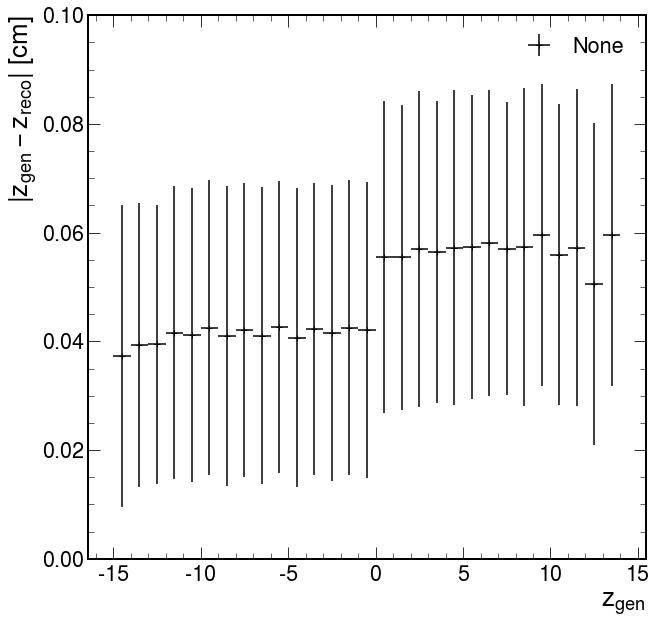

In [201]:
fh_res = plot_pv_resolution_z0(z0_gen = z0_mc, z0_reco=z0_reco_fh_c, bins =be)

# Primary Vertex Efficiency vs Z0

In [47]:
from pv_utils import plot_pv_efficiency_z0

In [48]:
help(plot_pv_efficiency_z0)

Help on function plot_pv_efficiency_z0 in module pv_utils:

plot_pv_efficiency_z0(z0_gen: <built-in function array>, z0_reco: <built-in function array>, bin_edges: <built-in function array>, delta: float = 0.1, label: str = 'none', xlim: list = [-15, 15]) -> dict



In [49]:
be = np.arange(-15, 16, 1)

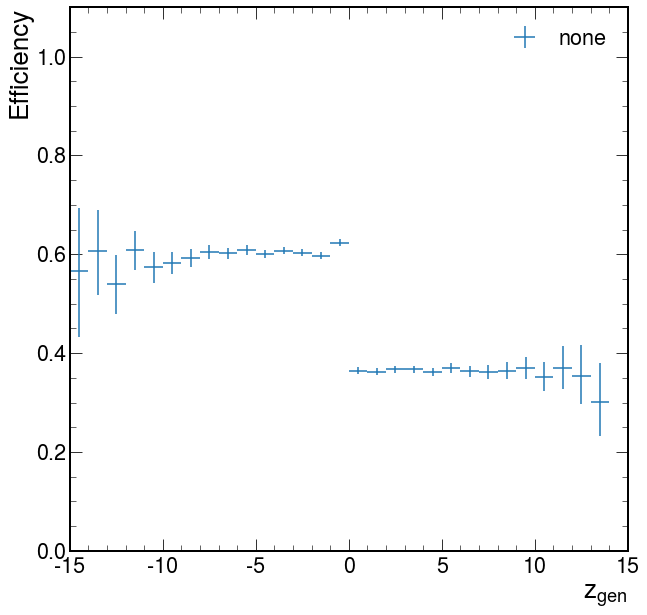

In [247]:
fh_plot = plot_pv_efficiency_z0(z0_gen= z0_mc, z0_reco=z0_reco_fh, bin_edges=be)

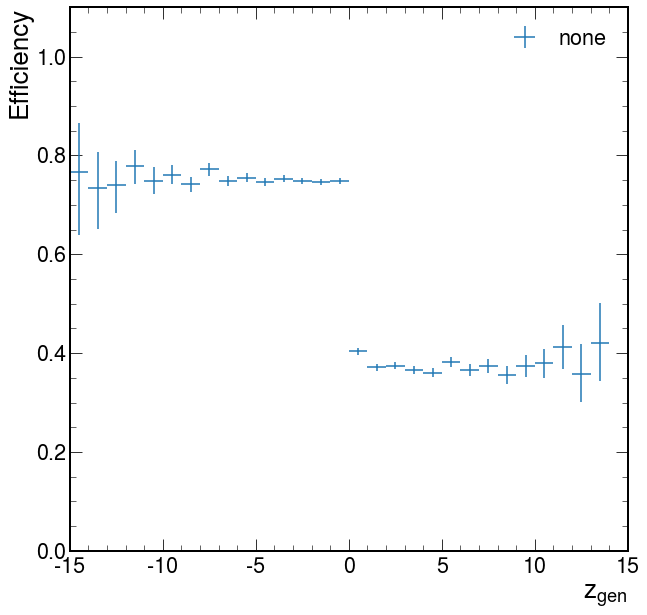

In [251]:
fh_c = plot_pv_efficiency_z0(z0_gen= z0_mc, z0_reco=z0_reco_fh_c, bin_edges=be)

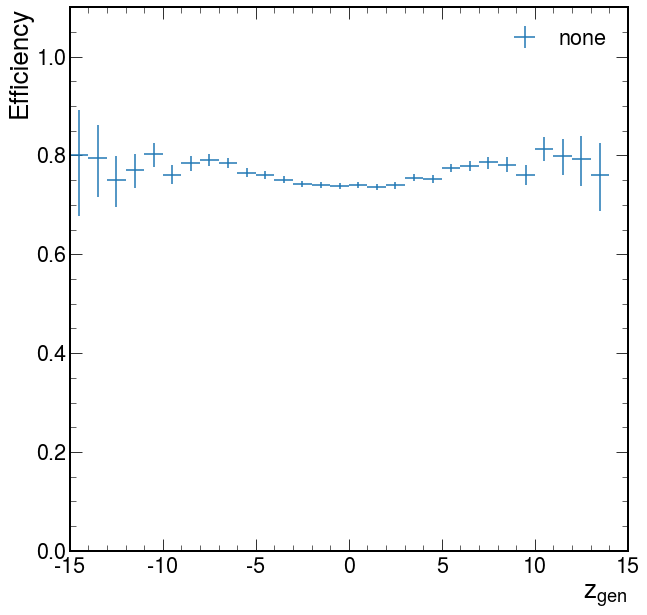

In [249]:
db_plot = plot_pv_efficiency_z0(z0_gen= z0_mc, z0_reco=z0_db['trk_z0'], bin_edges=be)

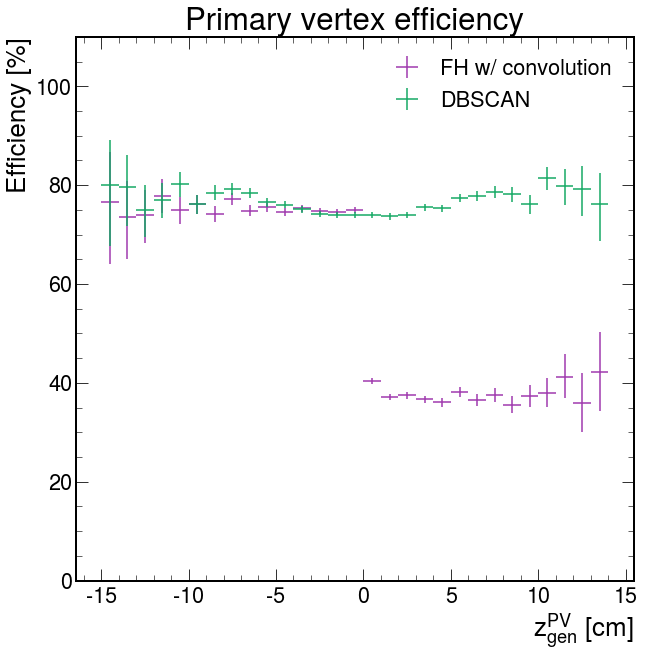

In [253]:
plt.errorbar(
    fh_c.x,
    100 * fh_c.eff,
    xerr=fh_c.error_x,
    yerr=[100 * fh_c.lower_error, 100 * fh_c.upper_error],
    ls="none",
    label="FH w/ convolution",
    color="#9E37AD",
)
plt.errorbar(
    db_plot.x,
    100 * db_plot.eff,
    xerr=db_plot.error_x,
    yerr=[100 * db_plot.lower_error, 100 * db_plot.upper_error],
    ls="none",
    label="DBSCAN",
    color="#12A863",
)
plt.legend()
plt.ylim(0, 110)
plt.xlabel(r"$z^{PV}_{gen}$ [cm]")
plt.ylabel("Efficiency [%]")
plt.title("Primary vertex efficiency")
plt.savefig('pv_eff.pdf', dpi=500, bbox_inches='tight')

### PROPOSED SOLUTION TO THE SHIFT

Take the median value of the difference between $z_0^{PV} - z_0^{Reco}$ when $z_0^{PV} \geq 0$ and then subtract this value from the original (positive) $z_0^{PV}$ 

# DEBUG FAST HISTO

**Select first event**

In [56]:
e1 = trk[0:159].copy()

In [57]:
e1

trk_pt   trk_eta   trk_phi  trk_d0    trk_z0  trk_fake  \
entry subentry                                                             
0     0         2.623967  1.301414 -0.289234   999.0 -0.878906         2   
      1         3.435026  0.566814 -0.159267   999.0  3.339844         2   
      2         3.774908  1.815973 -0.240375   999.0  4.921875         1   
      3         2.641448 -1.435747 -0.128747   999.0 -0.468750         2   
      4         2.320653  1.837421  0.032604   999.0  4.980469         1   
...                  ...       ...       ...     ...       ...       ...   
      154       2.026653 -2.021094 -1.062191   999.0 -0.410156         2   
      155       2.049097 -2.055119 -0.964472   999.0 -0.410156         2   
      156       2.222179 -2.426809 -0.693084   999.0  5.566406         2   
      157       2.563973  2.081842 -0.530004   999.0 -3.046875         2   
      158       2.303798  1.335547 -0.274176   999.0  4.804688         2   

                is_pv  fh_label  db_label  
entry subentry                             
0     0             0         0         0  
      1             0         0         0  
      2             1         1         1  
      3             0         0         0  
      4             1         1         1  
...               ...       ...       ...  
      154           0         0         0  
      155           0         0         0  
      156           0         0         0  
      157           0         0         0  
      158           0         0         1  

[159 rows x 9 columns]

In [58]:
bin_edges = be_fh

In [59]:
histo = np.histogram(e1.trk_z0, bins=bin_edges, weights=e1.trk_pt)[0]

Text(1, 0, 'z0')

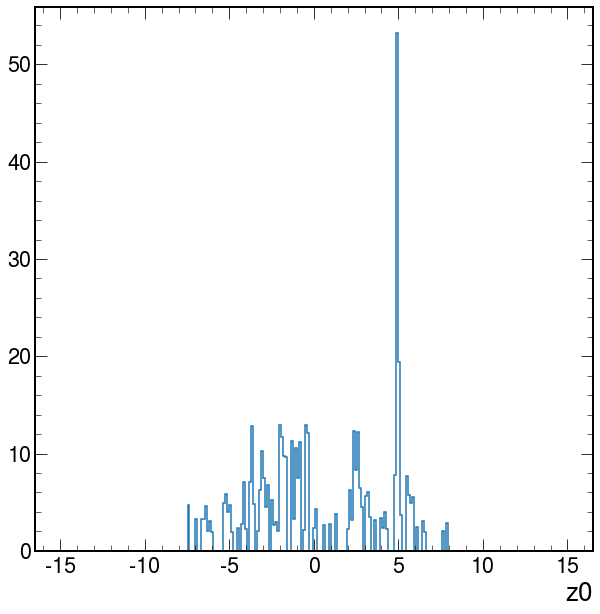

In [65]:
hep.histplot(histo, bin_edges)
plt.xlabel('z0')

In [66]:
histo.shape

(255,)

In [67]:
histo_conv = np.convolve(histo, [1,1,1], mode='same')

In [90]:
z0_index = np.argmax(histo)

In [76]:
z0_index_conv = np.argmax(histo_conv)

In [77]:
z0_index

169

In [78]:
z0_index_conv

169

In [79]:
halfBinWidth = 0.5*30.0/256.0

In [80]:
z0 = -15.0 + 30.0*z0_index_conv/256.0 + halfBinWidth

In [81]:
z0

4.86328125

In [84]:
histo_conv.max()

80.37664794921875

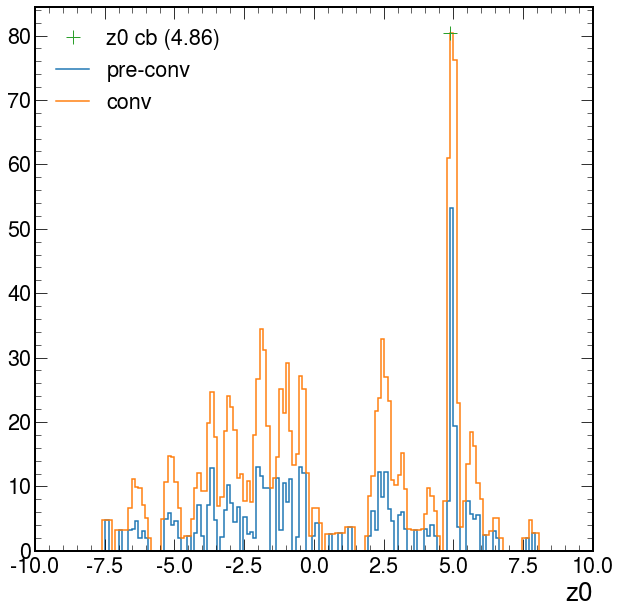

In [88]:
hep.histplot(histo, bin_edges, label = 'pre-conv')
hep.histplot(histo_conv, bin_edges, label='conv')
plt.xlabel('z0')
plt.xlim(-10, 10)
plt.plot(4.86328125, 80.3766479, '+',markersize=14, label = 'z0 cb (4.86)')
plt.legend(loc='upper left')



In [91]:
labels = np.zeros(len(e1.trk_z0), dtype=int)

In [92]:
max_idx = np.argmax(histo)

In [93]:
lower_bin_bound = bin_edges[max_idx]
upper_bin_bound = bin_edges[max_idx + 1]

In [94]:
in_max_bin_mask = (e1.trk_z0 > lower_bin_bound) & ( e1.trk_z0 <= upper_bin_bound)

In [95]:
labels[in_max_bin_mask] = 1

In [96]:
e1['labels'] = labels

In [97]:
e1

trk_pt   trk_eta   trk_phi  trk_d0    trk_z0  trk_fake  \
entry subentry                                                             
0     0         2.623967  1.301414 -0.289234   999.0 -0.878906         2   
      1         3.435026  0.566814 -0.159267   999.0  3.339844         2   
      2         3.774908  1.815973 -0.240375   999.0  4.921875         1   
      3         2.641448 -1.435747 -0.128747   999.0 -0.468750         2   
      4         2.320653  1.837421  0.032604   999.0  4.980469         1   
...                  ...       ...       ...     ...       ...       ...   
      154       2.026653 -2.021094 -1.062191   999.0 -0.410156         2   
      155       2.049097 -2.055119 -0.964472   999.0 -0.410156         2   
      156       2.222179 -2.426809 -0.693084   999.0  5.566406         2   
      157       2.563973  2.081842 -0.530004   999.0 -3.046875         2   
      158       2.303798  1.335547 -0.274176   999.0  4.804688         2   

                is_pv  fh_label  db_label  labels  
entry subentry                                     
0     0             0         0         0       0  
      1             0         0         0       0  
      2             1         1         1       1  
      3             0         0         0       0  
      4             1         1         1       1  
...               ...       ...       ...     ...  
      154           0         0         0       0  
      155           0         0         0       0  
      156           0         0         0       0  
      157           0         0         0       0  
      158           0         0         1       0  

[159 rows x 10 columns]

In [98]:
e1.loc[e1['labels']==1].groupby('entry')['trk_z0'].median().reset_index()

,entry,trk_z0
0,0,4.980469


In [ ]:
z0

In [ ]:
def fast_histo_event(z0: np.array, pt: np.array, bin_edges: np.array) -> pd.Series:
    "Event-level Fast Histo implementation to return the reconstructed primary vertex"

    histo = np.histogram(z0, bins=bin_edges, weights=pt)[0]
    
    histo = np.convolve(histo, [1,1,1], mode='same')
    
    labels = np.zeros(len(z0), dtype=int)
    

    max_idx = np.argmax(histo)

    lower_bin_bound = bin_edges[max_idx]
    upper_bin_bound = bin_edges[max_idx + 1]

    in_max_bin_mask = (z0 > lower_bin_bound) & (z0 <= upper_bin_bound)
    labels[in_max_bin_mask] = 1

    return labels

# DEBUG

In [232]:
e1 = trk.query('entry==0').copy()

In [237]:
e2 = trk.query('entry==1').copy()

Text(1, 0, '$\\eta$')

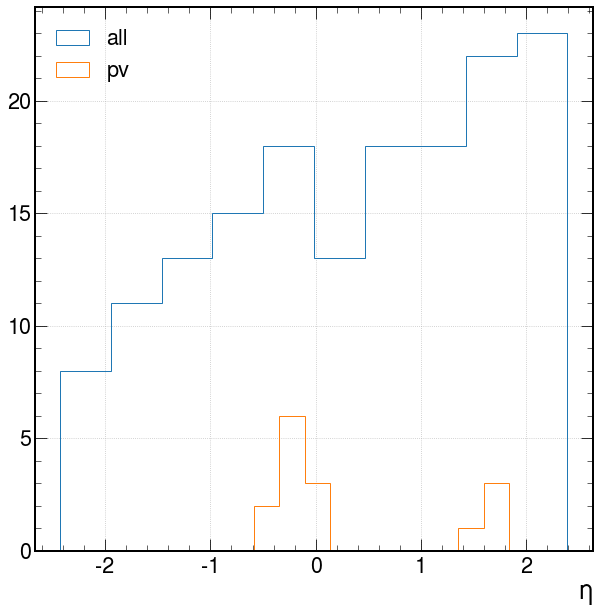

In [246]:
e1['trk_eta'].hist(histtype='step',label='all')
e1.loc[e1['is_pv']==1,'trk_eta'].hist(histtype='step',label='pv')
plt.legend(loc='upper left')
plt.xlabel(r'$\eta$')

Text(1, 0, '$\\eta$')

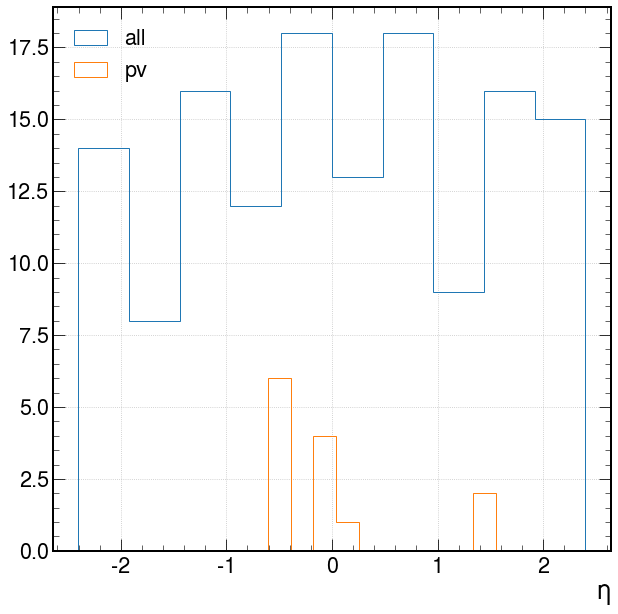

In [245]:
e2['trk_eta'].hist(histtype='step',label='all')
e2.loc[e2['is_pv']==1,'trk_eta'].hist(histtype='step',label='pv')
plt.legend(loc='upper left')
plt.xlabel(r'$\eta$')